# Settings script

In [5]:
MODEL_1 = True
MODEL_2 = False

RUN_RAYTUNE = False
USE_FULL_DATASET = True  # If false, use small dataset instead (10K pictures, 100 per class)

NUM_EPOCHS = 5

MANUAL_DATA_AUGMENTATION = False

LOGGING_FILENAME = "efficientnet_b0_food101_run_6"

# Ensure exactly one model is selected
assert sum([MODEL_1, MODEL_2]) == 1, "Exactly one model must be selected."

# Install dependencies

In [ ]:
#!pip install -r requirements.txt

# Imports

In [24]:
# Standard library
import os
import pathlib

# ML
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap.umap_ as umap

# TorchVision
import torchvision
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

# W&B
import wandb

# Ray Tune
#from ray import tune
#from ray.tune import CLIReporter
#from ray.tune.schedulers import ASHAScheduler


c:\Users\daria\gan-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set GPU variable

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


# Data paths

In [6]:
ROOT = pathlib.Path().resolve()

if USE_FULL_DATASET:
    IMAGE_DIR = ROOT / "data" / "archive" / "food-101" / "food-101" / "images"
else:
    IMAGE_DIR = ROOT / "data" / "food-101-small"

print("Using IMAGE_DIR =", IMAGE_DIR)

if not IMAGE_DIR.exists():
    raise FileNotFoundError(f"Missing dataset folder:\n{IMAGE_DIR}")

# Safety: avoid __MACOSX folders
bad_paths = list((ROOT / "data" / "archive" / "food-101").rglob("__MACOSX"))
if bad_paths:
    print("⚠ WARNING: __MACOSX folders detected.")

print("Dataset path OK.")

Using IMAGE_DIR = D:\University Masters\3rd semester\CV\IMTL\data\archive\food-101\food-101\images
⚠ WARNING: __MACOSX folders detected.
Dataset path OK.


# Data preprocessing

In [7]:
img_size = 224 # Needed width and height dimensions for EfficientNet

# Use AutoAugment for data augmentation
if MANUAL_DATA_AUGMENTATION:
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ])    

else:
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
    ])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

full_dataset = datasets.ImageFolder(IMAGE_DIR, transform=train_transform, allow_empty=True)
class_names = full_dataset.classes
num_classes = len(class_names)

print("Total images:", len(full_dataset))
print("Classes:", num_classes)

Total images: 101000
Classes: 101


# Split data into stratified sets

In [8]:

# labels for each sample in the ImageFolder dataset
labels = np.array(full_dataset.targets)  # shape: (N,)

n_samples = len(full_dataset)
print("Total samples:", n_samples)

# 1) First split: Train (70%) vs Temp (30% = Val+Test)
sss1 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.30,   # 30% goes to temp (val+test)
    random_state=42
)

train_idx, temp_idx = next(sss1.split(np.zeros(n_samples), labels))

# 2) Second split: Temp -> Val (15%) and Test (15%)
#    i.e. split temp into 50/50 => 0.15 / 0.15 of total
temp_labels = labels[temp_idx]

sss2 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.50,   # half of temp -> test, half -> val
    random_state=42
)

val_rel_idx, test_rel_idx = next(sss2.split(np.zeros(len(temp_labels)), temp_labels))

val_idx  = temp_idx[val_rel_idx]
test_idx = temp_idx[test_rel_idx]

# Build Subset datasets
train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)
test_ds  = Subset(full_dataset, test_idx)

print(f"Train size: {len(train_ds)}")
print(f"Val size:   {len(val_ds)}")
print(f"Test size:  {len(test_ds)}")


Total samples: 101000
Train size: 70700
Val size:   15150
Test size:  15150


# Create DataLoaders

In [9]:
val_ds.dataset.transform = test_transform
test_ds.dataset.transform = test_transform

batch_size_default = 32

train_loader = DataLoader(train_ds, batch_size=batch_size_default, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size_default, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size_default, shuffle=False)

# Build Model

In [10]:
def build_model_1(lr, num_classes):
    """EfficientNet-B0 model"""
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1
    model = efficientnet_b0(weights=weights)

    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    for p in model.features.parameters():
        p.requires_grad = False

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, criterion


def build_model_2(lr, num_classes):
    """Placeholder model — intentionally blank"""
    raise NotImplementedError("MODEL_2 not implemented yet.")

In [ ]:
if MODEL_1:
    build_model = build_model_1
elif MODEL_2:
    build_model = build_model_2

# Define training and evaluation functions

In [11]:
def train_one_epoch(model, loader, optimizer, criterion, device, epoch, log_interval=100):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(loader, desc=f"Training Epoch {epoch}", leave=False)

    for batch_idx, (imgs, labels) in enumerate(pbar):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        avg_loss_so_far = total_loss / total
        avg_acc_so_far = correct / total

        pbar.set_postfix({
            "loss": f"{avg_loss_so_far:.4f}",
            "acc": f"{100 * avg_acc_so_far:.2f}%"
        })

        # Optional: batch-level logging to W&B
        if (batch_idx + 1) % log_interval == 0:
            wandb.log(
                {
                    "batch/train_loss": loss.item(),
                    "batch/lr": optimizer.param_groups[0]["lr"],
                    "epoch": epoch,
                }
            )

    avg_loss = total_loss / total
    avg_acc = correct / total

    # Epoch-level logging to W&B
    wandb.log(
        {
            "epoch/train_loss": avg_loss,
            "epoch/train_accuracy": avg_acc,
            "epoch/train_error_rate": 1 - avg_acc,
            "epoch": epoch,
        }
    )

    return avg_loss, avg_acc

def evaluate(model, loader, criterion, device, epoch=None, split="val"):
    """
    Generic evaluation for val/test.
    split: "val" or "test" (used in W&B metric names).
    """
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    desc = f"Evaluating ({split})"
    if epoch is not None:
        desc += f" Epoch {epoch}"

    with torch.no_grad():
        pbar = tqdm(loader, desc=desc, leave=False)

        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

            avg_loss_so_far = total_loss / total
            avg_acc_so_far = correct / total

            pbar.set_postfix({
                "loss": f"{avg_loss_so_far:.4f}",
                "acc": f"{100 * avg_acc_so_far:.2f}%"
            })

    avg_loss = total_loss / total
    avg_acc = correct / total

    # Log to W&B if epoch is known (for val) or just once (for test)
    metric_prefix = f"{split}"
    log_data = {
        f"{metric_prefix}/loss": avg_loss,
        f"{metric_prefix}/accuracy": avg_acc,
        f"{metric_prefix}/error_rate": 1 - avg_acc,
    }
    if epoch is not None:
        log_data["epoch"] = epoch

    wandb.log(log_data)

    return avg_loss, avg_acc

# Define Hyperparameter Optimization

In [12]:
def train_one_epoch_raytune(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def tune_train(config):
    batch_size = config["batch_size"]
    lr = config["lr"]

    # local transforms
    train_ds.dataset.transform = train_transform
    val_ds.dataset.transform   = test_transform

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

    model, optimizer, criterion = build_model(lr, num_classes)

    for epoch in range(config["epochs"]):
        train_one_epoch_raytune(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        tune.report({"loss": float(val_loss), "accuracy": float(val_acc)})

# Run RayTune (If toggled on)

In [ ]:
if RUN_RAYTUNE:
    os.environ["RAY_DISABLE_METRICS_EXPORT"] = "1"

    search_space = {
        "lr": tune.loguniform(1e-5, 1e-2),
        "batch_size": tune.choice([16, 32, 64]),
        "epochs": 3
    }

    scheduler = ASHAScheduler(metric="accuracy", mode="max")
    reporter  = CLIReporter(metric_columns=["loss", "accuracy"])

    tuner = tune.Tuner(
        tune.with_resources(
            tune_train,
            resources={"cpu": 4, "gpu": 1 if torch.cuda.is_available() else 0},
        ),
        param_space=search_space,
        tune_config=tune.TuneConfig(
            scheduler=scheduler,
            num_samples=6,
        ),
        run_config=tune.RunConfig(progress_reporter=reporter),
    )

    results = tuner.fit()
    best = results.get_best_result(metric="accuracy", mode="max")

    print("Best config:", best.config)

    best_config = best.config

# Initialize model

In [14]:
if not RUN_RAYTUNE:
    model, optimizer, criterion = build_model_1(1e-3, num_classes)

## Build feature extractor

In [15]:
class EfficientNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.features = model.features
        self.avgpool = model.avgpool

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)          # (B, 1280, 1, 1)
        x = torch.flatten(x, 1)      # (B, 1280)
        return x


feat_model = EfficientNetFeatureExtractor(model).to(device)
feat_model.eval()

EfficientNetFeatureExtractor(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): C

## DataLoader for embeddings

In [16]:
embed_batch_size = 32
MAX_SAMPLES = 2000

embed_dataset = datasets.ImageFolder(IMAGE_DIR, transform=test_transform)
embed_train_ds = Subset(embed_dataset, train_ds.indices)  # same indices as your train split

embed_loader = DataLoader(
    embed_train_ds,
    batch_size=embed_batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

## Extract embeddings + labels

In [27]:
emb_list = []
lab_list = []
num_seen = 0

with torch.no_grad():
    for imgs, labels in tqdm(embed_loader, desc="Extracting embeddings"):
        imgs = imgs.to(device)
        feats = feat_model(imgs)  # (B, 1280)
        emb_list.append(feats.cpu())
        lab_list.append(labels.clone())

        num_seen += imgs.size(0)
        if num_seen >= MAX_SAMPLES:
            break

embeddings = torch.cat(emb_list, dim=0)[:MAX_SAMPLES].numpy()
labels     = torch.cat(lab_list, dim=0)[:MAX_SAMPLES].numpy()

print("Embeddings:", embeddings.shape)
print("Labels:", labels.shape)

Extracting embeddings:   0%|          | 0/2210 [00:00<?, ?it/s]c:\Users\daria\gan-env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Extracting embeddings:   3%|▎         | 62/2210 [01:16<43:57,  1.23s/it]  

Embeddings: (2000, 1280)
Labels: (2000,)


## t-SNE

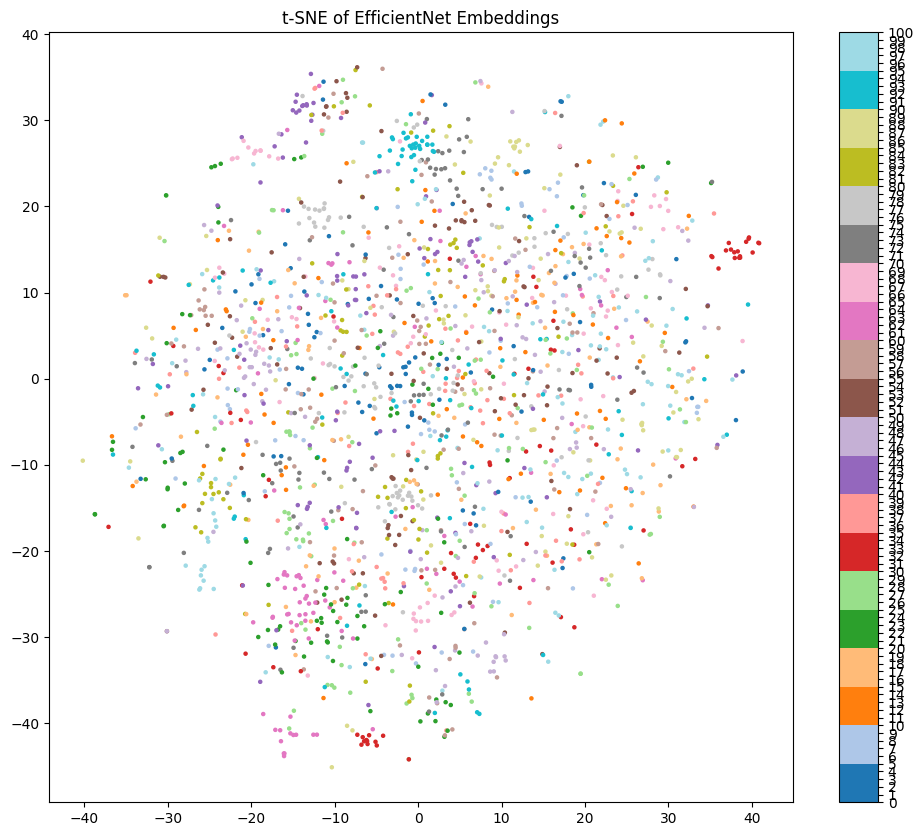

In [28]:
# Too many classes → subsample classes or points
N = min(2000, len(embeddings))
X = embeddings[:N]
y = labels[:N]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y[:N], cmap='tab20', s=5)
plt.title("t-SNE of EfficientNet Embeddings")
plt.colorbar(scatter, ticks=range(len(set(y[:N]))))
plt.show()


## UMAP
Food-101 has exactly the same number of images per class -> do not need to do balanced sampling for UMAP.

In [29]:
import numpy as np

N_SAMPLES = min(1000, len(embeddings)) # total, not per class

indices = np.random.choice(len(embeddings), size=N_SAMPLES, replace=False)
X = embeddings[indices]
y = labels[indices]

print("Subset:", X.shape, y.shape)

Subset: (1000, 1280) (1000,)


In [30]:
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

X_umap = umap_model.fit_transform(X)
print(X_umap.shape)

c:\Users\daria\gan-env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(1000, 2)


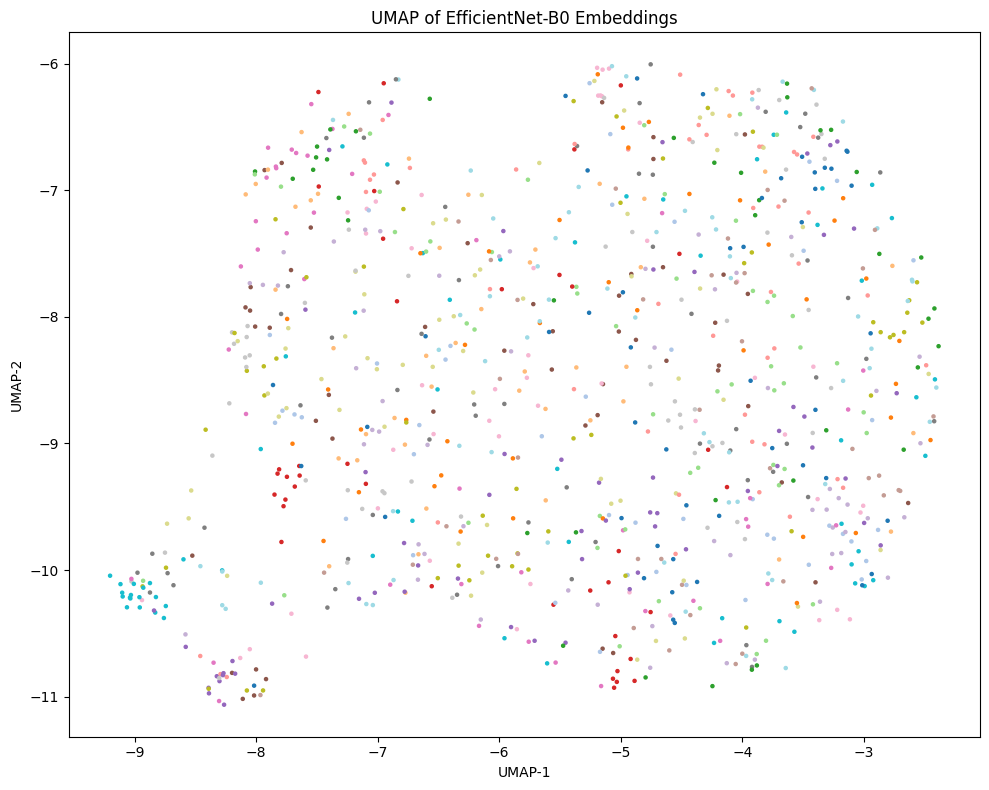

In [31]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='tab20', s=5)
plt.title("UMAP of EfficientNet-B0 Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

# Logging

In [ ]:
if not RUN_RAYTUNE:
    # W&B init
    wandb.login()  # will prompt you the first time in this environment

    wandb_config = {
        "model_name": "efficientnet_b0",
        "img_size": img_size,
        "batch_size": 32,
        "optimizer": "Adam",
        "learning_rate": 1e-3,
        "train_size": len(train_ds),
        "val_size": len(val_ds),
        "test_size": len(test_ds),
        "num_classes": num_classes,
        "transfer_learning": True,      
        "feature_extractor_frozen": True,
        "augmentation": "AutoAugment_IMAGENET"
    }

    run = wandb.init(
        project="IMTL",
        config=wandb_config,
        name=LOGGING_FILENAME,  # you can change this per run
    )

    wandb.watch(model, log="all", log_freq=100)

# Train the Model

In [ ]:
if not RUN_RAYTUNE:
    epochs = NUM_EPOCHS

    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch+1}/{epochs} ---")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
        val_loss, val_acc     = evaluate(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

# Test the Model

In [ ]:
if not RUN_RAYTUNE:
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print("\n=== Test Results ===")
    print(f"Test Loss:     {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

# Evaluation results

In [ ]:
# --- Evaluation + Top-N Confusion Logging ---

model.eval()   # IMPORTANT: inference mode

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

## Confusion matrix

In [ ]:
# --- Confusion matrix ---
cm = confusion_matrix(all_labels, all_preds)

# --- Top-N confused class pairs (better than 101×101 heatmap) ---
N = 20  # adjust as needed

off = cm.copy()
np.fill_diagonal(off, 0)

indices = np.dstack(np.unravel_index(
    np.argsort(off.ravel())[::-1], off.shape
))[0][:N]

rows = []
for (t, p) in indices:
    rows.append([
        class_names[t],
        class_names[p],
        int(cm[t, p])
    ])

table = wandb.Table(
    columns=["true_class", "predicted_class", "count"],
    data=rows
)

wandb.log({"top_confusions": table})

## Per-class accuracy (sorted)

In [ ]:
# --- Per-class accuracy sorted (best -> worst) ---

num_classes = len(class_names)
class_correct = np.zeros(num_classes, dtype=int)
class_total = np.zeros(num_classes, dtype=int)

for t, p in zip(all_labels, all_preds):
    class_total[t] += 1
    if t == p:
        class_correct[t] += 1

class_accuracy = (class_correct / class_total)

# build sorted list
sorted_idx = np.argsort(class_accuracy)[::-1]  # best first

rows = []
for idx in sorted_idx:
    rows.append([
        class_names[idx],
        float(class_accuracy[idx]),
        int(class_correct[idx]),
        int(class_total[idx])
    ])

acc_table = wandb.Table(
    columns=["class", "accuracy", "correct", "total"],
    data=rows
)

wandb.log({"per_class_accuracy_sorted": acc_table})


## Top 10 most misclassified classes

In [ ]:
# --- Find top misclassified classes ---

num_classes = len(class_names)
class_correct = np.zeros(num_classes, dtype=int)
class_total   = np.zeros(num_classes, dtype=int)

for t, p in zip(all_labels, all_preds):
    class_total[t] += 1
    if t == p:
        class_correct[t] += 1

class_errors = class_total - class_correct

# sort classes by number of misclassifications
sorted_err_idx = np.argsort(class_errors)[::-1]

top_k = 10
top_mis_classes = sorted_err_idx[:top_k]

# --- Collect misclassified images for these classes ---

images_by_class = {cls: [] for cls in top_mis_classes}

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        _, preds = outputs.max(1)

        mismatch = preds != labels

        for img, pred, true in zip(imgs[mismatch], preds[mismatch], labels[mismatch]):
            t = true.item()
            if t in images_by_class and len(images_by_class[t]) < 10:
                images_by_class[t].append(
                    wandb.Image(
                        img.cpu(),
                        caption=f"true={class_names[t]}, pred={class_names[pred.item()]}"
                    )
                )

        # stop early if all 10 classes reached 10 images
        if all(len(v) >= 10 for v in images_by_class.values()):
            break

# --- Log grouped images to W&B ---

log_dict = {}
for cls in top_mis_classes:
    name = class_names[cls]
    log_dict[f"misclassified/{name}"] = images_by_class[cls]

wandb.log(log_dict)


## GradCam for wrong predictions

In [ ]:
# ============================
# GRAD-CAM FOR EFFICIENTNET-B0
# ============================

import torch
import torch.nn.functional as F
import cv2
import numpy as np
import wandb


# ----------------------------
# 1. Grad-CAM class
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out

    def _save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, x, class_idx):
        self.model.zero_grad()

        out = self.model(x)
        loss = out[:, class_idx]
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam


# ----------------------------
# 2. Correct EfficientNet-B0 target layer
# ----------------------------
target_layer = model.features[7][0].block[1][0]

# enable gradients only on this layer
for p in target_layer.parameters():
    p.requires_grad = True

gradcam = GradCAM(model, target_layer)


# ----------------------------
# 3. Overlay helper
# ----------------------------
def overlay_cam(img_tensor, cam):
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())

    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(cam * 255), cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32) / 255.0

    overlay = img * 0.5 + heatmap * 0.5
    overlay = np.clip(overlay, 0, 1)
    return overlay


# ----------------------------
# 3.5  SINGLE HEAT LEGEND (colorbar)
# ----------------------------
# ----------------------------
# 3.5  SINGLE HEAT LEGEND (colorbar with text)
# ----------------------------
import matplotlib.pyplot as plt

def generate_colorbar_with_text(height=300, width=60):
    """
    Returns a (H,W,3) numpy image containing:
    - JET colormap
    - Labels 'High', 'Mid', 'Low'
    - Numeric ticks 1.0, 0.5, 0.0
    """
    # Create vertical gradient
    gradient = np.linspace(1, 0, height).reshape(height, 1)
    gradient = np.repeat(gradient, width, axis=1)
    gradient_uint8 = np.uint8(gradient * 255)
    jet = cv2.applyColorMap(gradient_uint8, cv2.COLORMAP_JET)
    jet = cv2.cvtColor(jet, cv2.COLOR_BGR2RGB)

    # Create a canvas for text (slightly wider)
    canvas = np.ones((height, width + 120, 3), dtype=np.float32)
    canvas[:, :width] = jet / 255.0

    # Add text using cv2
    font = cv2.FONT_HERSHEY_SIMPLEX

    # High (red)
    cv2.putText(canvas, "High (1.0)", (width + 10, 20),
                font, 0.5, (1, 1, 1), 1, cv2.LINE_AA)

    # Middle
    cv2.putText(canvas, "Mid (0.5)", (width + 10, height // 2),
                font, 0.5, (1, 1, 1), 1, cv2.LINE_AA)

    # Low (blue)
    cv2.putText(canvas, "Low (0.0)", (width + 10, height - 10),
                font, 0.5, (1, 1, 1), 1, cv2.LINE_AA)

    return canvas


# Generate + log legend
colorbar_img = generate_colorbar_with_text()
wandb.log({"gradcam/color_scale": wandb.Image(colorbar_img)})



# ----------------------------
# 4. Grad-CAM on misclassified images
# ----------------------------
gradcam_results = []
model.eval()

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    outputs = model(imgs)
    _, preds = outputs.max(1)

    mismatch = preds != labels
    mismatch_idx = torch.where(mismatch)[0]

    for idx in mismatch_idx:
        img = imgs[idx].unsqueeze(0)
        class_idx = preds[idx].item()

        cam = gradcam(img, class_idx=class_idx)[0].detach().cpu().numpy()

        overlay = overlay_cam(imgs[idx].cpu(), cam)

        gradcam_results.append(
            wandb.Image(
                overlay,
                caption=f"true={class_names[labels[idx].item()]}, pred={class_names[preds[idx].item()]}"
            )
        )

        if len(gradcam_results) >= 20:
            break

    if len(gradcam_results) >= 20:
        break


# ----------------------------
# 5. Log all Grad-CAM images
# ----------------------------
wandb.log({
    "gradcam/misclassified": gradcam_results
})


## Misclassified examples

In [ ]:
misclassified_images = []
misclassified_preds = []
misclassified_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        _, preds = outputs.max(1)

        mismatch = preds != labels
        if mismatch.any():
            for img, pred, true in zip(imgs[mismatch], preds[mismatch], labels[mismatch]):
                misclassified_images.append(img.cpu())
                misclassified_preds.append(pred.cpu().item())
                misclassified_labels.append(true.cpu().item())

                # keep it small
                if len(misclassified_images) >= 32:
                    break
        if len(misclassified_images) >= 32:
            break

# Log to W&B as images
wandb.log({
    "test/misclassified_examples": [
        wandb.Image(
            img,
            caption=f"pred: {class_names[p]}, true: {class_names[t]}"
        )
        for img, p, t in zip(misclassified_images, misclassified_preds, misclassified_labels)
    ]
})


In [ ]:
wandb.finish()